# Scent Lab — Hardware‑Free Demo

This notebook demonstrates the **AI scent‑classification prototype** using synthetic VOC/environment features, model training/evaluation, and a quick look at artifacts you can ship with your portfolio.

## 1) Setup
Install dependencies if needed.

In [1]:
# If running locally, you can uncomment to install:
# !pip install -q scikit-learn pandas numpy matplotlib
import json, pickle, os, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

BASE = Path(".")
DATA_CSV = BASE / "synthetic_scent_data.csv"
assert DATA_CSV.exists(), f"Missing {DATA_CSV}. (Repo should include it.)"
df = pd.read_csv(DATA_CSV)
df.head()

Matplotlib is building the font cache; this may take a moment.


,raw_voc,gas_res,humidity,temperature,voc_delta,voc_slope,gas_ratio,humid_comp_voc,label
0,1.763238,2832.894101,41.546231,24.213302,-0.022303,0.015613,0.000622,1.757785,citrus
1,2.014142,2494.488656,38.267383,23.272011,0.049010,0.008596,0.000807,2.021121,citrus
2,2.286068,2177.072405,43.823342,24.525316,0.014059,0.024577,0.001050,2.268587,citrus
3,2.129281,2334.818744,38.117237,24.658395,-0.034878,-0.019348,0.000912,2.137299,citrus
4,1.964831,2546.224366,38.090154,22.634275,-0.043297,-0.003317,0.000771,1.972336,citrus


## 2) Train/Test Split + Models

In [2]:
X = df.drop(columns=["label"])
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=7)

pipelines = {
    "knn": Pipeline([("scaler", StandardScaler()), ("clf", KNeighborsClassifier(n_neighbors=7))]),
    "svm_rbf": Pipeline([("scaler", StandardScaler()), ("clf", SVC(kernel="rbf", C=2.0, gamma="scale", probability=True))]),
    "rf": Pipeline([("clf", RandomForestClassifier(n_estimators=160, random_state=7))])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cv_scores = {}
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy")
    cv_scores[name] = (scores.mean(), scores.std())

cv_scores

{'knn': (np.float64(0.9099999999999999), np.float64(0.010030816714037662)),
 'svm_rbf': (np.float64(0.915), np.float64(0.010333930687632371)),
 'rf': (np.float64(0.9199999999999999), np.float64(0.008854098583616245))}

## 3) Pick Best Model & Evaluate

In [3]:
test_scores = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    test_scores[name] = pipe.score(X_test, y_test)

best_name = max(test_scores, key=test_scores.get)
best_model = pipelines[best_name]
print("Best model:", best_name, "test accuracy:", test_scores[best_name])

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best model: svm_rbf test accuracy: 0.94
              precision    recall  f1-score   support

     aquatic       0.99      1.00      1.00       150
      citrus       0.90      0.86      0.88       150
      floral       0.87      0.91      0.89       150
       woody       0.99      0.99      0.99       150

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



## 4) Confusion Matrix

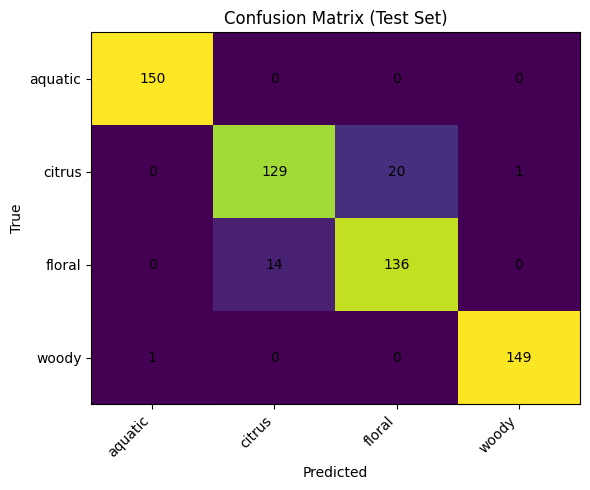

In [4]:
families = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=families)

plt.figure(figsize=(6,5))
plt.imshow(cm, aspect="auto")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(families)), families, rotation=45, ha="right")
plt.yticks(range(len(families)), families)
for i in range(len(families)):
    for j in range(len(families)):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

## 5) Live Demo (Terminal)
Run this in a terminal to simulate the sensor stream and classify frames in real time:

In [5]:
# (Instructions only)
print("""# In a terminal, from this folder:
# pip install scikit-learn pandas numpy matplotlib
# Choose a family: citrus | floral | woody | aquatic
python mock_stream.py floral | python classify_stream.py
""")

# In a terminal, from this folder:
# pip install scikit-learn pandas numpy matplotlib
# Choose a family: citrus | floral | woody | aquatic
python mock_stream.py floral | python classify_stream.py



## 6) Next Steps
- Replace `mock_stream.py` with a real I²C reader for BME688.
- Keep JSON keys identical so `classify_stream.py` works unchanged.
- Version control with Git; attach confusion matrix image to README.